### Задание 1

- СУБД: MS SQL. 
- Название БД: qwerty.
- Пользовать: user
- Пароль: password
- IP-адрес сервера: 85.114.8.250.

- **Схема БД**
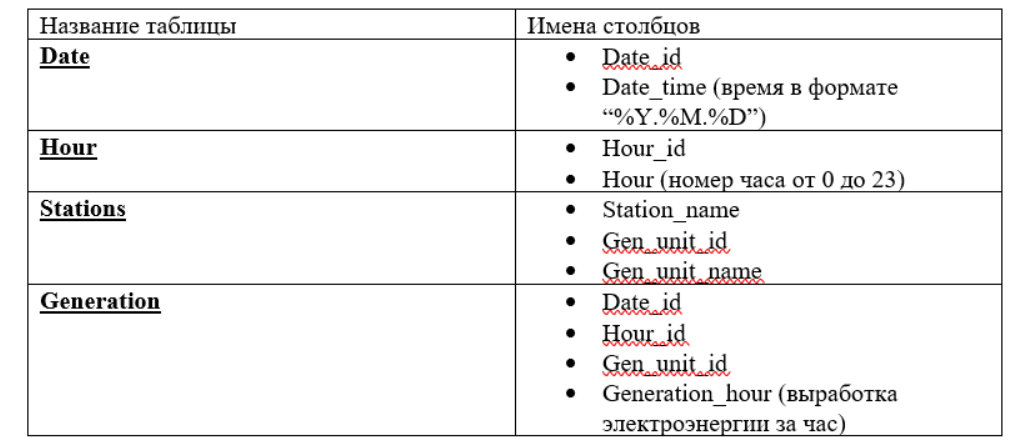

### 1. Подключение к БД
Необходимо подключиться к MS SQL СУБД. Можно использовать различные библиотеки (`pymssql` или `pyodbc`)

**Т.к. доступа к БД по заданию нет, то скрипт не выполнять!**

In [ ]:
# Используем модуль pymssql 
import pymssql

# Параметры подключения 
SERVER_NAME = 'qwerty'
USER_NAME = 'user'
PASSWORD = 'password'
DB_IP = '85.114.8.250.'

# Подключение
conn = pymssql.connect(server=SERVER_NAME,
                       user=USER_NAME,
                       password=PASSWORD,
                       database=DB_IP)

# Определяем объект курсор
cursor = conn.cursor()

# Запрос из задания 
query = """
    SELECT
        YEAR(d.Date_time) AS 'Год',
        MONTH(d.Date_time) AS 'Месяц',
        DAY(d.Date_time) AS 'Месяц',
        AVG(g.Generation_hour) AS 'Средняя выработка за сутки',
        SUM(g.Generation_hour) AS 'Суммарная выработка за сутки'
    FROM Stations s INNER JOIN Generation g ON (s.Gen_unit_id = g.Gen_unit_id)
                    INNER JOIN Hour h ON (g.Hour_id = h.Hour_id)
                    INNER JOIN Date d ON (g.Date_id = d.Date_id)
    WHERE MONTH(d.Date_time) = 1 AND YEAR(d.Date_time) = 2021 
    GROUP BY
        d.Date_time,
        s.Station_name,
        s.Gem_unit_name
"""

# Выполняем запрос 
cursor.execute(query)

# Получение результата 
row = cursor.fetchone()

# Закрываем соединение с БД
conn.close()

### 2. Запрос к БД
- Необходимо выполнить запрос (выгрузить данные за **январь 2021** и получить таблицы со следующей структурой)
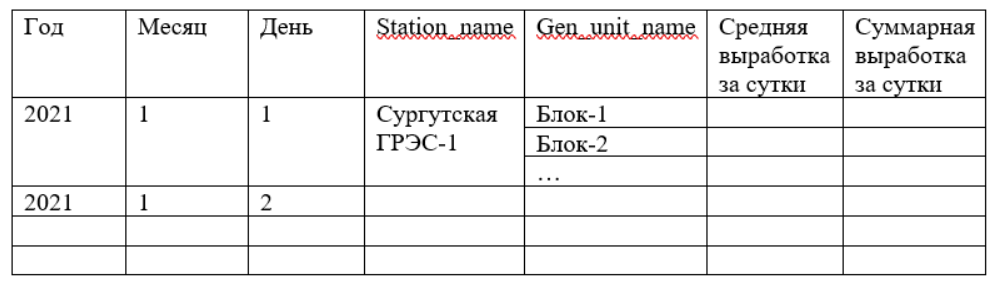

### Задание 2

1.	Загрузить и обработать данные (инструкция по содержанию и расположению данных в файле `data.docx`).
2.	Выполнить прогноз **среднесуточной цены продажи электроэнергии по ЦЗ «Европа» на 1 месяц** (горизонт прогноза – 30 суток).
3.	Отобразить на графике обучающую выборку, валидационную (если использовалась) и прогноз (выделить разным цветом).


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.api as sm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_validate, TimeSeriesSplit

import warnings 

SEED = 42
warnings.filterwarnings('ignore')

In [41]:
# Загрузка данных 
data_2018 = pd.read_excel('data_2018.xlsx', engine='openpyxl')
data_2019 = pd.read_excel('data_2019.xlsx', engine='openpyxl')
data_2020 = pd.read_excel('data_2020.xlsx', engine='openpyxl')

### Небольшой Preprocessing

In [43]:
# Объеденим данные 
dfs = [data_2018, data_2019, data_2020]
data = pd.concat(dfs)

# Проверка на пропуски 
print('Total NaNs: ', data.isna().sum().sum())

Total NaNs:  0


In [44]:
# Так как данные только в рамках ЦЗ Европа, то удалим данный признак 
data.drop(columns='ЦЗ', inplace=True)

# Значения признака ЗСП с пробелами, исправим 
data['ЗСП'] = data['ЗСП'].apply(lambda x: x.strip())

In [45]:
# Сохраняем итоговый DataFrame
data.to_csv('main_data.csv', index=False)

Признак который необходимо спрогнозировать - `Цена_продажи`. 

Задачу можно решать в разрезе признака `ЗСП (Зона Свободного Перетока)` так как мы имеем часовые тики для каждой уникальной `ЗСП` на каждую дату.

Однако об этом ничего не сказано и в задании требуется просто осуществить прогноз **среднесуточной цены по  ЦЗ «Европа» на 1 месяц**


Для получения временного ряда сгруппируем цену по каждой дате и возьмем среднее

In [46]:
# Загрузка данных 
data = pd.read_csv('main_data.csv')

# Получаем временной ряд среднесуточной цены по ЦЗ «Европа» с 2018-01-01 по 2020-08-24
price_ts = data.groupby('Дата', as_index=False).agg({'Цена_продажи': 'mean'})

In [47]:
# Изменим дату
price_ts['Дата'] = pd.to_datetime(price_ts['Дата'])

# Устанавливаем дату как индекс 
price_ts = price_ts.set_index('Дата')
price_ts

,Цена_продажи
Дата,
2018-01-01,1011.108528
2018-01-02,1151.511167
2018-01-03,1220.935000
2018-01-04,1274.934472
2018-01-05,1221.152639
...,...
2020-08-20,1280.272761
2020-08-21,1255.152572
2020-08-22,1200.055653


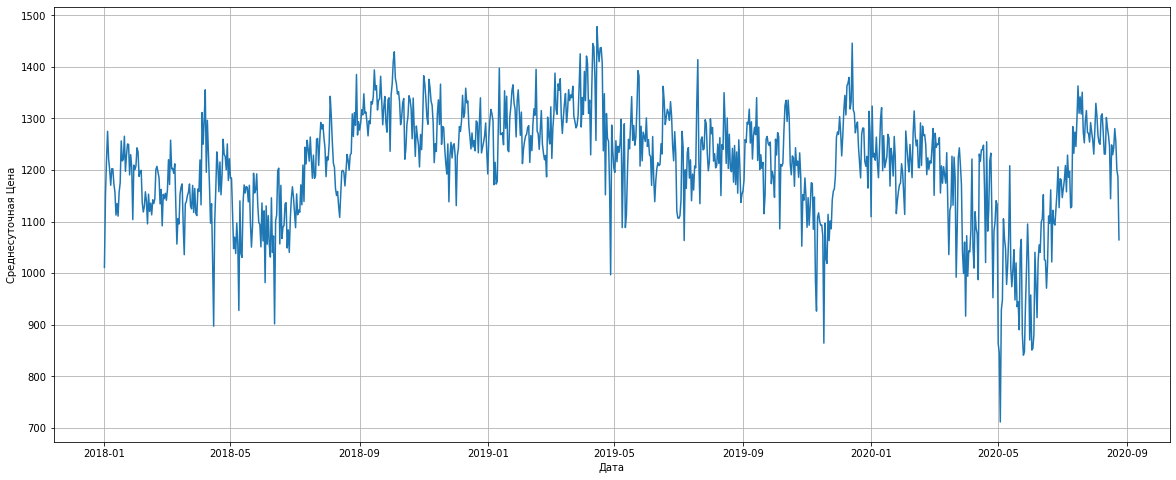

In [48]:
# Для визуализации ряда
def plot_sereis(series, x_name, y_name):
    plt.figure(figsize=(20,8))
    plt.plot(series)
    plt.grid(True)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
plot_sereis(price_ts['Цена_продажи'], x_name='Дата', y_name='Среднесуточная Цена')

Отчетливо виден изменяющийся тренд, сезонность, также имеются аномалии

Взглянем на декомпозицию данного ряда 

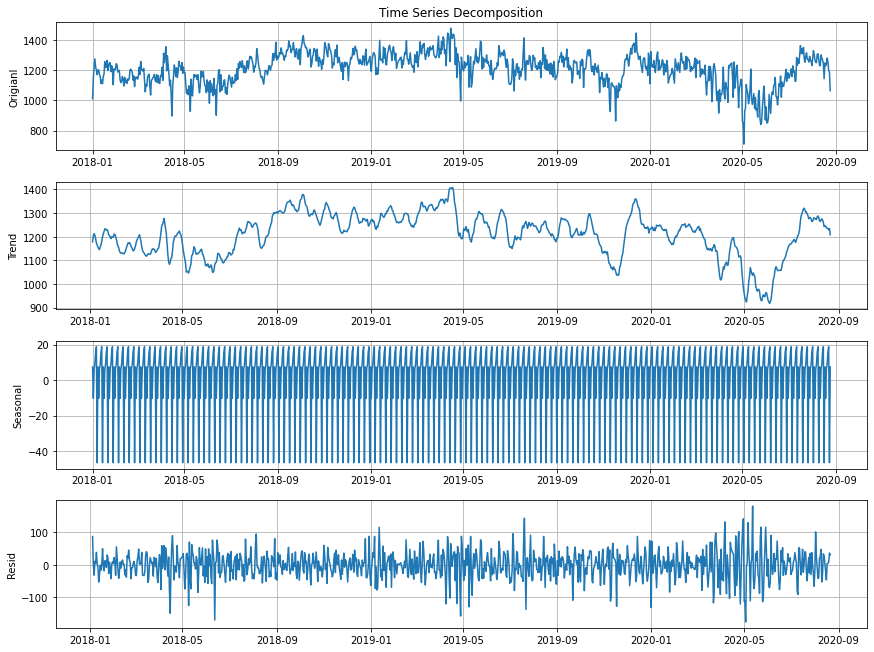

In [49]:
# Определим функцию для декомпозиции ВР
def plot_decomposition(series, figsize = (12, 9), grid=True):
    ts_compnts = sm.tsa.seasonal_decompose(series)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    plt.tight_layout()
    ax[0].set_title('Time Series Decomposition')
    
    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)
    
    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)
        
plot_decomposition(price_ts['Цена_продажи'])

На первый взгляд, какие-либо явные закономерности выявить сложно. Разве что только выделить тренд ряда

Также посмотрим на ряд в разрезе месяца/полгода/год

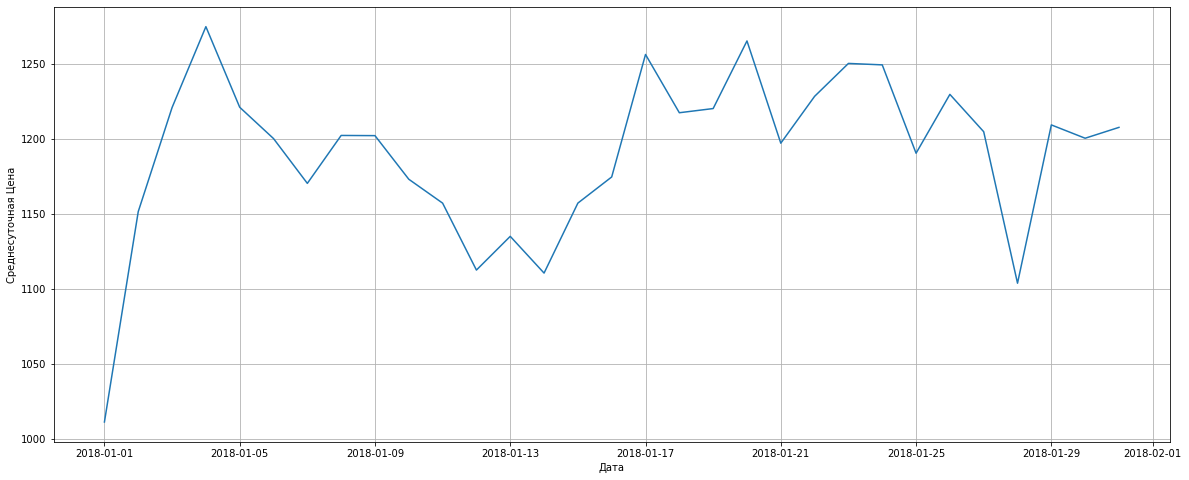

In [50]:
# Месячное изменение цены 
plot_sereis(price_ts.loc['2018-01-01': '2018-01-31']['Цена_продажи'], x_name='Дата', y_name='Среднесуточная Цена')

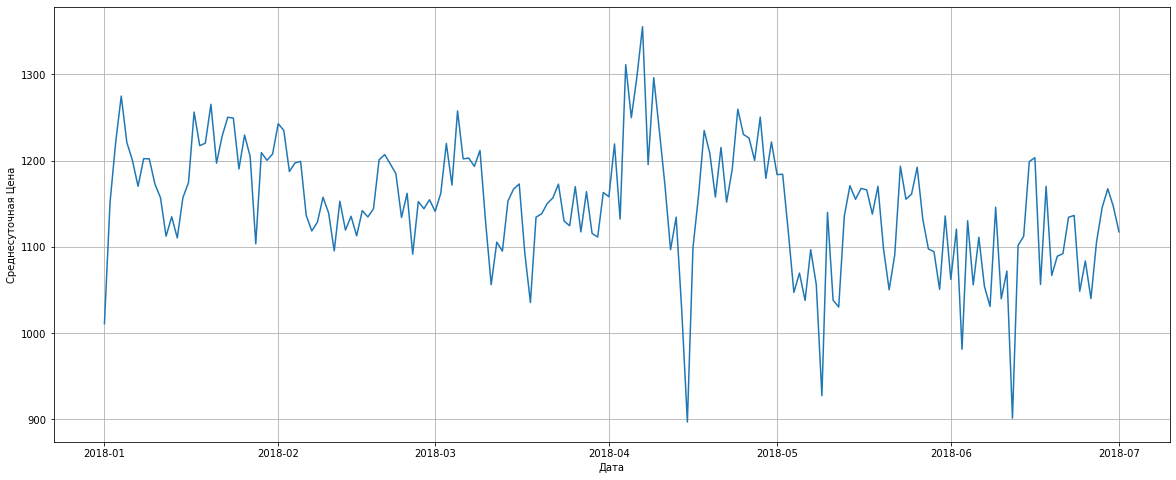

In [51]:
# Полугодовое изменение цены 
plot_sereis(price_ts.loc['2018-01-01': '2018-07-01']['Цена_продажи'], x_name='Дата', y_name='Среднесуточная Цена')

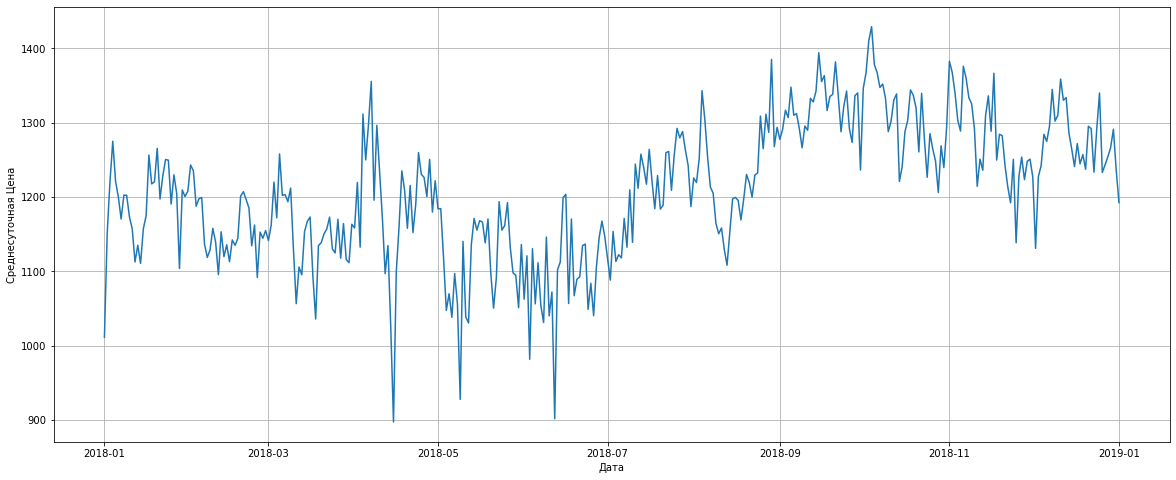

In [52]:
# Годовое изменение цены 
plot_sereis(price_ts.loc['2018-01-01': '2019-01-01']['Цена_продажи'], x_name='Дата', y_name='Среднесуточная Цена')

### Подходы к Решению Задачи
Для прогнозирования цены можно выбрать несколько моделей:
- Авторегрессионные (SARIMA/SARIMAX) 
- Бустинг на временных признаках (праздники, выходные)
- Нейросети LSTM/GRU

**Мы сравним несколько моделей (бустинг и нейросети)** и выберем лучшую

Нейросети не будут требовать какого-либо извлечения признаков. Для прогнозирования временных рядов очень хорошо подходят реккурентные сети, например LSTM (long Short Term Memory Networks - сети с краткосрочной памятью) или GRU (Gated Recurrent Unit). Данные архитектуры предназначены для работы с последовательностями, идеально для временного ряда

Для бустинга придётся немного повозиться и извлечь временные признаки "руками"

### Основные Метрики 
Выберем классические метрики для задачи регрессии:
- MSE (Среднеквадратичная Ошибка)
- RMSE (Корень из Среднеквадратичной Ошибки)

In [53]:
# Определим MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Определим RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Разделение на Train/Test
По условию задания необходимо спрогнозировать цену на месяц вперёд. Поэтому отрежем последний месяц в `test`, а все остальное в `train`

In [54]:
# Определим последнее наблюдение в ряде 
last_date_value = price_ts.index[-1]
print('Дата последнего наблюдения: ', last_date_value)

Дата последнего наблюдения:  2020-08-24 00:00:00


In [55]:
# Разобьем ряд на train/test
train_data = price_ts.loc[:'2020-07-31 00:00:00']
test_data = price_ts.loc['2020-08-01 00:00:00':]

### LSTM
Построим модель LSTM

In [56]:
# Нейросети требует масштабирования признаков, используем MinMaxScaling 
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
train_scaled[:5]

array([[0.39114514],
       [0.5742675 ],
       [0.66481463],
       [0.7352443 ],
       [0.66509849]])

In [57]:
# Определим функцию для подготовки train_data и test_data
def prepare_train_data(train, window_size):
    X_train = []
    y_train = [] # цена на следующий день
    
    for i in range(window_size, train.shape[0]):
        X_train_chunks = np.reshape(train[i-window_size:i, 0], (window_size, 1))
        X_train.append(X_train_chunks)
        y_train.append(train[i, 0])
        
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    
    return X_train, y_train

def prepare_test_data(test, train, window_size, scaler):
    X_test = []
    y_test = []
    
    initial_array = np.vstack((train, test))
    # Входными данные начинаются с индекса all_data_rows_n - test_data_rows_n - window_size
    new_test = initial_array[initial_array.shape[0] - test.shape[0] - window_size:].reshape(-1, 1)
    # Чтобы ошибка была корректной, масштабируем
    new_test_scaled = scaler.transform(new_test)
    
    new_index = initial_array.shape[0] - train.shape[0] + window_size
    for i in range(window_size, new_index):
        X_test_chunks = np.reshape(new_test_scaled[i-window_size:i, 0], (window_size, 1))
        X_test.append(X_test_chunks)
        y_test.append(new_test_scaled[i, 0])
        
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    
    return X_test, y_test

In [58]:
# Данные для обучения и валидации 
X_train, y_train = prepare_train_data(train_scaled, window_size=30)
X_test, y_test = prepare_test_data(test_data, train_scaled, window_size=7, scaler=scaler)

In [59]:
tf.random.set_seed(SEED)

# Определяем модель
model = Sequential()

# Входной слой
model.add(LSTM(units=5, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dropout(0.5))

model.add(LSTM(units=5, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой 
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 5)             140       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 5)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [60]:
%%time

tf.random.set_seed(SEED)

# Задаем гиперпараметры модели 
model.compile(optimizer='sgd', 
              loss='mae', 
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

fitted_model = model.fit(X_train,
                         y_train,
                         validation_data=(X_test, y_test),
                         epochs=100,
                         batch_size=32,
                         callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=20));

Epoch 1/100
29/29 [==============================] - 2s 33ms/step - loss: 0.3920 - mean_absolute_percentage_error: 215696.8281 - val_loss: 0.2606 - val_mean_absolute_percentage_error: 36.1755
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.2042 - mean_absolute_percentage_error: 292399.4375 - val_loss: 0.1876 - val_mean_absolute_percentage_error: 26.0469
Epoch 3/100
29/29 [==============================] - 1s 23ms/step - loss: 0.1619 - mean_absolute_percentage_error: 416731.8750 - val_loss: 0.1256 - val_mean_absolute_percentage_error: 17.6219
Epoch 4/100
29/29 [==============================] - 1s 24ms/step - loss: 0.1339 - mean_absolute_percentage_error: 794201.3750 - val_loss: 0.0904 - val_mean_absolute_percentage_error: 12.9395
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 0.1189 - mean_absolute_percentage_error: 661114.2500 - val_loss: 0.0962 - val_mean_absolute_percentage_error: 13.6913
Epoch 6/100
29/29 [=====================

In [61]:
# Прогнозируем
model_pred_scaled = model.predict(X_test)

# Совершаем обратную трансформацию 
model_preds = scaler.inverse_transform(model_pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Рассчитаем ошибку прогноза 
print('Test MAPE: ', mean_absolute_percentage_error(actual, model_preds))
print('Test RMSE: ', root_mean_squared_error(actual, model_preds))

Test MAPE:  4.173732852602066
Test RMSE:  61.089970565617584


In [62]:
# Создадим для удобства 
forecast_df = test_data
forecast_df['forecast'] = model_preds

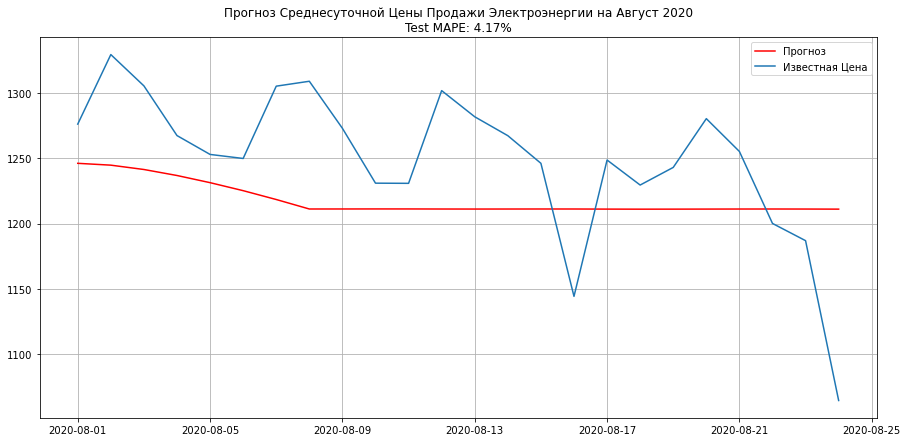

In [63]:
# Визуализируем прогноз модели на месяц
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="Прогноз")
plt.plot(forecast_df['Цена_продажи'], label="Известная Цена")
plt.title(f'Прогноз Среднесуточной Цены Продажи Электроэнергии на Август 2020\nTest MAPE: {round(mean_absolute_percentage_error(actual, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

Модель запомнила наулучшие параметры до роста ошибки при помощи `EarlyStopping` ранней остановки

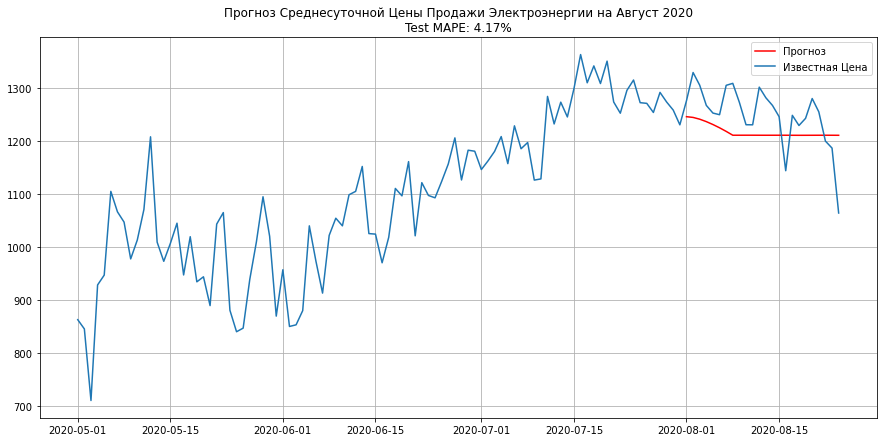

In [64]:
# Визуализируем прогноз модели на месяц
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['forecast'], "r", label="Прогноз")
plt.plot(price_ts['2020-05-01':], label="Известная Цена")
plt.title(f'Прогноз Среднесуточной Цены Продажи Электроэнергии на Август 2020\nTest MAPE: {round(mean_absolute_percentage_error(actual, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

Известные и спрогнозированные значения были сведены в таблицу

In [67]:
forecast_df.head()

,Цена_продажи,forecast
Дата,,
2020-08-01,1276.095078,1246.081665
2020-08-02,1329.322056,1244.673584
2020-08-03,1305.355186,1241.352173
2020-08-04,1267.324178,1236.755127
2020-08-05,1252.884531,1231.272583


### Gradient Boosting 

### Генерация Признаков
Произведем извлечение основных признаков из временного ряда 

In [68]:
price_ts

,Цена_продажи
Дата,
2018-01-01,1011.108528
2018-01-02,1151.511167
2018-01-03,1220.935000
2018-01-04,1274.934472
2018-01-05,1221.152639
...,...
2020-08-20,1280.272761
2020-08-21,1255.152572
2020-08-22,1200.055653


In [77]:
# Признаки времени 
def get_time_features(series):
    features_df = series.copy() # чтобы не изменять исходный series
    
    # Признаки времени
    features_df['day_of_month'] = features_df.index.day
    features_df['day_name'] = features_df.index.day_name()
    features_df['week_of_year'] = features_df.index.weekofyear

    # Выходной и Праздники (Бинарные)
    features_df['is_weekend'] = features_df.index.weekday.isin([5,6])*1 # Умножаем на 1 чтобы получить 0/1 вместо True/False
 
    # Начало/Конец месяца, квартала, года 
    features_df['is_month_start'] = features_df.index.is_month_start*1
    features_df['is_month_end'] = features_df.index.is_month_end*1
    features_df['is_quarter_start'] = features_df.index.is_quarter_start*1
    features_df['is_quarter_end'] = features_df.index.is_quarter_end*1
    features_df['is_year_start'] = features_df.index.is_year_start*1
    features_df['is_year_end'] = features_df.index.is_year_end*1
    
    # Время года 
    seasons = {1:'Winter', 2:'Spring', 3:'Summer', 4:'Autumn'}
    features_df['season'] = ((features_df.index.month % 12 + 3)//3).map(seasons)
     
    return features_df 

In [78]:
# Лаги ряда 
def get_lags(df, target_col_name, lag_start=1, lag_end=48, drop_target_col=True):
    features_df = df.copy()
    for i in range(lag_start, lag_end+1):
        features_df[f"lag_{i}"] = features_df[target_col_name].shift(i)
    features_df = features_df.dropna(axis='rows')
    
    if drop_target_col:
        features_df = features_df.drop(columns=target_col_name)
    return features_df

# График автокорреляционной функции 
def plot_acf_pacf(series, lags=30, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(series.values, lags=lags, ax=ax)
    plt.grid(True)
    
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(series.values, lags=lags, ax=ax)
    plt.grid(True)

Для определения необходимого числа лагов используем график автокорреляционной функции

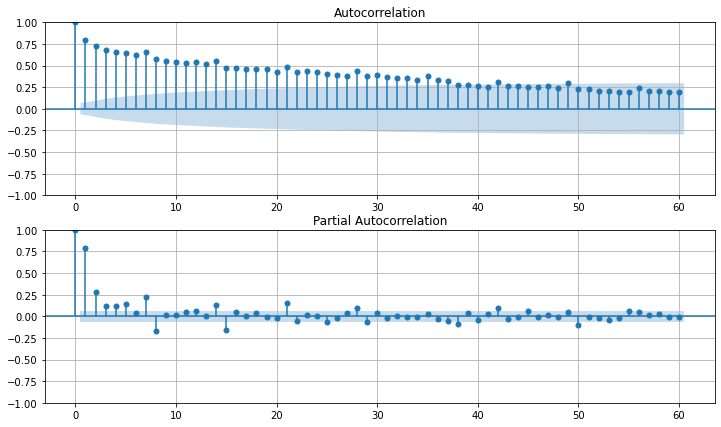

In [79]:
# Рассмотрим первые 60 лагов 
plot_acf_pacf(price_ts, lags=60)

Каждое 7 наблюдение коррелирует (поэтому ограничимся 7/10 лагами), значит конец недели как-то влияет на цену продажи



In [80]:
# Признаки на скользящем окне 
def get_rolling_window_features(series, target_col_name, window_size=[12, 24], statistics=['avg'], drop_target_col=False):
    res_df = pd.DataFrame()
    res_df[target_col_name] = series[target_col_name]
    for statistic in statistics:
        for size in window_size:
            if statistic == 'avg':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).mean()
            elif statistic == 'min':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).min()
            elif statistic == 'max':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).max()
            elif statistic == 'sum':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).sum()
            elif statistic == 'std':
                res_df[f'rolling_{statistic}_{size}'] = series[target_col_name].rolling(size).std()
    res_df = res_df.dropna()
    if drop_target_col:
        res_df = res_df.drop(columns=target_col_name)
    return res_df

In [81]:
# Формируем признаки
time_features = get_time_features(price_ts)
lag_features = get_lags(price_ts, target_col_name='Цена_продажи', lag_start=1, lag_end=10, drop_target_col=True)
rolling_win_feat = get_rolling_window_features(price_ts, target_col_name='Цена_продажи', 
                                               window_size=[12, 24], statistics=['avg', 'std', 'sum'], 
                                               drop_target_col=False).drop(columns='Цена_продажи')

features_df = pd.concat([time_features, lag_features, rolling_win_feat], axis='columns')

features_df.fillna(0, inplace=True) # !

### Разделение на Train/Test
По условию задания необходимо сделать прогноз на следующие сутки и оценить качество модели 

Отрежем последний день и добавим его в `test` (это послдение 4 точки)

In [89]:
# Данные для train/test
train_data = features_df[:'2020-07-31']
inference_data = features_df['2020-08-01':]

# Матрица признаков и таргет 
X = train_data.drop(columns='Цена_продажи')
y = train_data['Цена_продажи']

### Модель
В качестве модели выбирем градиентный бустинг `CatBoost`

In [116]:
# Определяем основной разрез метрик
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error),
    'rmse': make_scorer(root_mean_squared_error)
    }

# Определяем модель c начальными параметрами
model = CatBoostRegressor(iterations=100,
                          learning_rate=0.48,
                          depth=6,
                          l2_leaf_reg=0.55,
                          logging_level='Silent',
                          cat_features=['day_name', 'season', 'day_of_month', 'week_of_year'],
                          loss_function='RMSE',
                          bootstrap_type='Bayesian',
                          random_strength=1.5,
                          random_seed=SEED, 
                          early_stopping_rounds=100,
                          task_type='CPU')

# Кросс-Валидируемся
cv_results = cross_validate(model, X=X, y=y,
                            cv=TimeSeriesSplit(n_splits=10),
                            scoring=scoring,
                            error_score='raise')

# Результаты 
cv_df = pd.DataFrame(cv_results)
cv_df[cv_df.columns[2:]].mean()

test_mape     5.050293
test_rmse    75.676713
dtype: float64

Получили хорошее качество на кросс-валидации для 10 фолдов

**В среднем прогноз ошибается на 5% или примерно на 75 рублей**

Можно добавить еще признаки и улучшить качество прогноза, но для BaseLine очень даже неплохо

### Inference
Теперь обучим модель и оценим ошибку на тестовой выборке. Примерно должны получить ошибку близкую или ниже/чуть выше `CV-error`

In [119]:
# Test Data
X_test = inference_data.drop(columns='Цена_продажи')
y_test = inference_data['Цена_продажи']

# Фитим Модель 
model.fit(X, y)
model_preds = model.predict(X_test)

# Снова смотрим на метрики 
print('Test MAPE: ', mean_absolute_percentage_error(y_test, model_preds))
print('Test RMSE: ', root_mean_squared_error(y_test, model_preds))

Test MAPE:  3.530431951233103
Test RMSE:  56.35377364993468


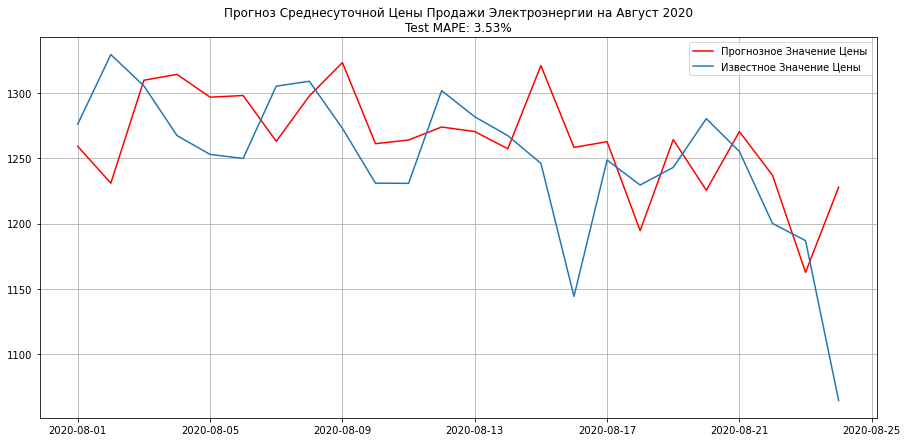

In [131]:
# Оформим прогноз в DataFrame
forecast_df = pd.DataFrame(y_test)
forecast_df['Прогноз'] = model_preds

# Визуализируем прогноз модели 
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['Прогноз'], "r", label="Прогнозное Значение Цены")
plt.plot(forecast_df['Цена_продажи'], label="Известное Значение Цены")
plt.title(f'Прогноз Среднесуточной Цены Продажи Электроэнергии на Август 2020\nTest MAPE: {round(mean_absolute_percentage_error(y_test, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

In [132]:
forecast_df.head()

,Цена_продажи,Прогноз
Дата,,
2020-08-01,1276.095078,1259.081581
2020-08-02,1329.322056,1230.878042
2020-08-03,1305.355186,1309.690526
2020-08-04,1267.324178,1314.158138
2020-08-05,1252.884531,1296.696500


Очень хорошие показатели, **в среднем мы ошибаемся на 56 рублей**

**Также взглянем как модель обучилась**

In [133]:
train_for_df = pd.DataFrame(train_data['Цена_продажи'])
train_for_df['Прогноз'] = model.predict(X)
train_for_df.head()

,Цена_продажи,Прогноз
Дата,,
2018-01-01,1011.108528,1009.103836
2018-01-02,1151.511167,1196.594640
2018-01-03,1220.935000,1226.727194
2018-01-04,1274.934472,1226.629684
2018-01-05,1221.152639,1212.921050


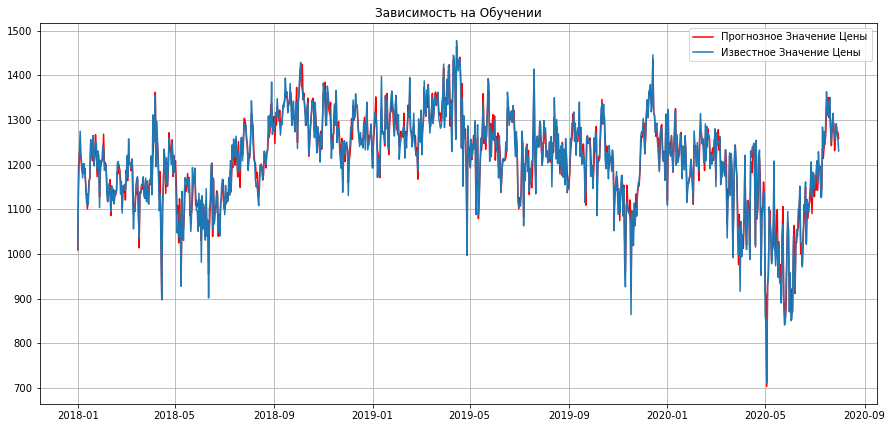

In [135]:
plt.figure(figsize=(15, 7))
plt.plot(train_for_df['Прогноз'], "r", label="Прогнозное Значение Цены")
plt.plot(train_for_df['Цена_продажи'], label="Известное Значение Цены")
plt.title(f'Зависимость на Обучении')
plt.legend(loc="best")
plt.grid(True);

Видно как модель очень хорошо извлекла основные зависимости от Цены Продажи на обучении и совершила очень хороший прогноз

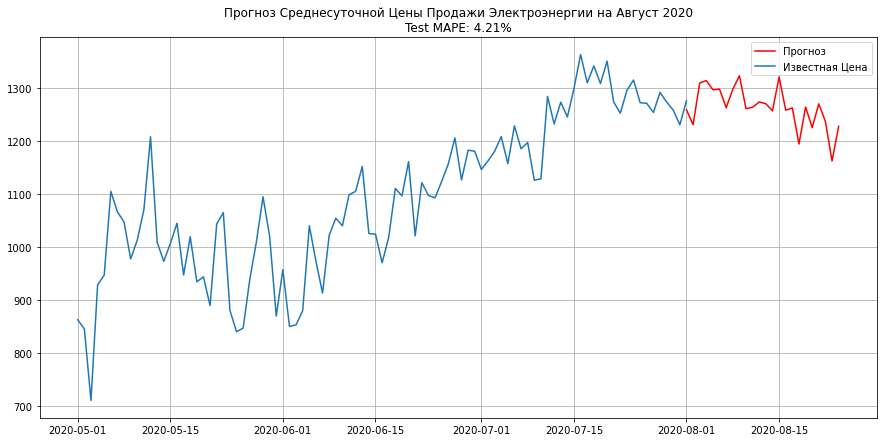

In [139]:
plt.figure(figsize=(15, 7))
plt.plot(forecast_df['Прогноз'], "r", label="Прогноз")
plt.plot(price_ts['2020-05-01':'2020-08-01'], label="Известная Цена")
plt.title(f'Прогноз Среднесуточной Цены Продажи Электроэнергии на Август 2020\nTest MAPE: {round(mean_absolute_percentage_error(actual, model_preds),2)}%')
plt.legend(loc="best")
plt.grid(True);

В качестве итоговой модели выбираем CatBoost